In [66]:
import torch
import torch.nn as nn
from torchvision.models import resnet34, ResNet34_Weights
import os
import cv2
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

In [67]:
import copy
import json
import torch
import numpy as np
import torch.nn as nn
from collections import defaultdict
from pathlib import Path
from xxhash import xxh64_digest


class Keypoint:
    def __init__(self, kind, x, y, score=None):
        self.kind = kind
        self.x = x
        self.y = y
        self.score = score

    def resize(self, in_size, out_size):
        img_w, img_h = in_size
        new_w, new_h = out_size

        self.x *= new_w / img_w
        self.y *= new_h / img_h

        return self

    def resized(self, in_size, out_size):
        return copy.deepcopy(self).resize(in_size, out_size)

    def distance(self, other):
        return np.hypot(self.x - other.x, self.y - other.y)

    def normalize(self, size):
        w, h = size
        self.x /= w
        self.y /= h
        return self

    def normalized(self, size):
        return copy.deepcopy(self).normalize(size)

    def json_repr(self):
        return {
            "kind": self.kind,
            "location": {"x": self.x, "y": self.y},
            "score": self.score,
        }

    @staticmethod
    def from_json(json_dict):
        kind = json_dict["kind"]
        location = json_dict["location"]
        (x, y) = location["x"], location["y"]
        score = json_dict.get("score")

        return Keypoint(kind, x, y, score)

    def __repr__(self):
        return f"Keypoint(kind: {self.kind}, x: {self.x}, y: {self.y}, score: {self.score})"


class Box:
    def __init__(self, x_min, y_min, x_max, y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max

    @property
    def x_mid(self):
        return (self.x_max + self.x_min) / 2

    @property
    def y_mid(self):
        return (self.y_max + self.y_min) / 2

    @property
    def width(self):
        return abs(self.x_max - self.x_min)

    @property
    def height(self):
        return abs(self.y_max - self.y_min)

    def resize(self, in_size, out_size):
        iw, ih = in_size
        ow, oh = out_size
        rw, rh = ow / iw, oh / ih
        self.x_min *= rw
        self.y_min *= rh
        self.x_max *= rw
        self.y_max *= rh
        return self

    def resized(self, in_size, out_size):
        return copy.deepcopy(self).reize(in_size, out_size)

    def normalize(self, size):
        self.x_min /= size[0]
        self.y_min /= size[1]
        self.x_max /= size[0]
        self.y_max /= size[1]
        return self

    def normalized(self, size):
        return copy.deepcopy(self).normalize(size)

    def yolo_coords(self, size):
        return (
            self.x_mid / size[0],
            self.y_mid / size[1],
            self.width / size[0],
            self.height / size[1],
        )

    def standardize(self):
        if self.x_min > self.x_max:
            self.x_min, self.x_max = self.x_max, self.x_min
        if self.y_min > self.y_max:
            self.y_min, self.y_max = self.y_max, self.y_min
        return self

    def standardized(self):
        return copy.deepcopy(self).standardize()

    def json_repr(self):
        return {
            "x_min": self.x_min,
            "y_min": self.y_min,
            "x_max": self.x_max,
            "y_max": self.y_max,
        }

    @staticmethod
    def from_json(json_dict):
        if json_dict is None:
            return None
        x_min, y_min, x_max, y_max = (
            json_dict["x_min"],
            json_dict["y_min"],
            json_dict["x_max"],
            json_dict["y_max"],
        )
        return Box(x_min, y_min, x_max, y_max)

    def __repr__(self):
        return f"Box(x_min: {self.x_min}, y_min: {self.y_min}, x_max: {self.x_max}, y_max: {self.y_max})"


class Object:
    def __init__(self, name, anchor, parts=None, box=None):
        self.name = name
        self.anchor = anchor
        self.parts = parts or []
        self.box = box

    @property
    def x(self):
        return self.anchor.x

    @property
    def y(self):
        return self.anchor.y

    @x.setter
    def x(self, new_value):
        self.anchor.x = new_value

    @y.setter
    def y(self, new_value):
        self.anchor.y = new_value

    def resize(self, in_size, out_size):
        self.anchor.resize(in_size, out_size)

        if self.box is not None:
            self.box.resize(in_size, out_size)

        for part in self.parts:
            part.resize(in_size, out_size)

        return self

    def resized(self, in_size, out_size):
        return copy.deepcopy(self).resize(in_size, out_size)

    def distance(self, other):
        return self.anchor.distance(other.anchor)

    def normalize(self, size):
        self.anchor.normalize(size)
        if self.box is not None:
            self.box.normalize(size)

        for part in self.parts:
            part.normalize(size)

        return self

    def normalized(self, size):
        return copy.deepcopy(self).normalize(size)

    def json_repr(self):
        parts = [self.anchor.json_repr()]
        parts += (part.json_repr() for part in self.parts)
        box = self.box.json_repr() if self.box else None
        return {"label": self.name, "box": box, "parts": parts}

    @staticmethod
    def from_json(json_dict, anchor_name):
        name = json_dict["label"]
        box = Box.from_json(json_dict["box"])
        anchor = None
        parts = []

        for part in json_dict["parts"]:
            part = Keypoint.from_json(part)
            if part.kind == anchor_name:
                assert (
                    anchor is None
                ), f"More than one anchor found for object, achor must be unique."
                anchor = part
            else:
                parts.append(part)

        assert (
            anchor is not None
        ), f"Anchor part with name '{anchor_name}' not found while decoding JSON file."
        return Object(name, anchor, parts, box)

    @property
    def nb_parts(self):
        return len(self.parts)

    def __repr__(self):
        return f"Object(name: {self.name}, anchor: {self.anchor}, parts: {self.parts}, box: {self.box})"


class ImageAnnotation:
    def __init__(self, image_path, objects=None, img_size=None):
        self.image_path = Path(image_path)
        self.objects = objects or []
        self.img_size = img_size

    @property
    def image_name(self):
        return self.image_path.name

    @property
    def image_stem(self):
        return self.image_path.stem

    def normalize(self, size=None):
        size = size or self.img_size
        assert size, f"Annotation for '{self.image_path}' does not have a size."

        for obj in self.objects:
            obj.normalize(size)

        return self

    def normalized(self, size=None):
        return copy.deepcopy(self).normalize(size)

    @staticmethod
    def from_json(file: Path, anchor_name: str):
        data = json.loads(file.read_text())
        image_path = Path(data["image_path"])
        img_size = data.get("img_size", None)
        objects = [Object.from_json(obj, anchor_name) for obj in data["objects"]]

        return ImageAnnotation(image_path, objects, img_size)

    def json_repr(self):
        return {
            "image_path": str(self.image_path.expanduser().resolve()),
            "img_size": self.img_size,
            "objects": [obj.json_repr() for obj in self.objects],
        }

    def save_json(self, save_dir=None):
        save_dir = Path(save_dir or "detections/")
        mkdir_if_needed(save_dir)
        save_name = save_dir / self.image_path.with_suffix(".json").name
        save_name.write_text(json.dumps(self.json_repr(), indent=2))

    def __repr__(self):
        return f"ImageAnnotation(name: {self.image_name}, objects: {self.objects}, img_size: {self.img_size})"

    def __len__(self):
        return len(self.objects)

    @property
    def nb_parts(self):
        return sum(obj.nb_parts for obj in self.objects)

    def resize(self, in_size, out_size):
        for obj in self.objects:
            obj.resize(in_size, out_size)
        return self

    def resized(self, in_size, out_size):
        return copy.deepcopy(self).resize(in_size, out_size)

    @property
    def is_empty(self):
        return len(self) == 0


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0.0
        self.count = 0
        self.avg = 0.0

    def update(self, value):
        self.sum += value
        self.count += 1
        self.avg = self.sum / self.count
        return self.avg


def files_with_extension(folder: Path, extension: str):
    return [f for f in Path(folder).iterdir() if f.suffix == extension]


def mkdir_if_needed(directory):
    Path(directory).mkdir(exist_ok=True)


def set_seed(seed="1975846251"):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)


# feat: (B, J, C), ind: (B, N)
def gather(feat: torch.Tensor, ind: torch.Tensor):
    return feat.squeeze(-1).gather(1, ind.squeeze(-1))  # (B, N, C)


# feat: (B, C, H, W), ind: (B, N)
def transpose_and_gather(feat: torch.Tensor, ind: torch.Tensor):
    ind = ind.unsqueeze(1).expand(-1, feat.size(1), -1)  # (B, C, N)
    feat = feat.view(feat.size(0), feat.size(1), -1)  # (B, C, J = H * W)
    feat = feat.gather(2, ind)  # (B, C, N)
    return feat.permute(0, 2, 1)  # (B, N, C)


# input: Tensor
def clamped_sigmoid(input: torch.Tensor):
    output = torch.sigmoid(input)
    return clamp_in_0_1(output)


def clamp_in_0_1(tensor: torch.Tensor):
    return torch.clamp(tensor, min=1e-6, max=1 - 1e-6)


def clip_annotation(annotation, img_size):
    (img_w, img_h) = img_size

    for obj in annotation.objects:
        obj.x = np.clip(obj.x, 0, img_w - 1)
        obj.y = np.clip(obj.y, 0, img_h - 1)

        for part in obj.parts:
            part.x = np.clip(part.x, 0, img_w - 1)
            part.y = np.clip(part.y, 0, img_h - 1)

        if obj.box is not None:
            obj.box.x_min = np.clip(obj.box.x_min, 0, img_w - 1)
            obj.box.x_max = np.clip(obj.box.x_max, 0, img_w - 1)
            obj.box.y_min = np.clip(obj.box.y_min, 0, img_h - 1)
            obj.box.y_max = np.clip(obj.box.y_max, 0, img_h - 1)

    return annotation


def hflip_annotation(annotation, img_size):
    img_w, _ = img_size

    for obj in annotation.objects:
        obj.x = img_w - obj.x - 1

        for part in obj.parts:
            part.x = img_w - part.x - 1

        if obj.box is not None:
            x_max = img_w - obj.box.x_min - 1
            x_min = img_w - obj.box.x_max - 1
            obj.box.x_min, obj.box.x_max = x_min, x_max

    return annotation


def vflip_annotation(annotation, img_size):
    _, img_h = img_size

    for obj in annotation.objects:
        obj.y = img_h - obj.y - 1

        for part in obj.parts:
            part.y = img_h - part.y - 1

        if obj.box is not None:
            y_max = img_h - obj.box.y_min - 1
            y_min = img_h - obj.box.y_max - 1
            obj.box.y_min, obj.box.y_max = y_min, y_max

    return annotation


def gaussian_2d(X, Y, mu1, mu2, sigma):
    return torch.exp((-((X - mu1) ** 2) - (Y - mu2) ** 2) / (2 * sigma**2))


def hypot(
    input: torch.Tensor, dim: int = -1, *, output: torch.Tensor | None = None
) -> torch.Tensor:
    assert (
        input.size(dim) == 2
    ), f"the size of dimension {dim} ({input.size(dim)}) should be 2"

    shape = list(input.shape)
    shape.pop(dim)
    output = torch.empty(shape, device=input.device)

    squared = torch.square(input)
    torch.sum(squared, dim=dim, out=output)
    torch.sqrt(output, out=output)

    return output


# heatmaps: (B, C, H, W)
def nms(heatmaps: torch.Tensor):
    max_values = nn.functional.max_pool2d(heatmaps, kernel_size=5, stride=1, padding=2)
    return (heatmaps == max_values) * heatmaps  # (B, C, H, W)


# scores: (B, C, H, W)
def topk(scores: torch.Tensor, k: int = 100):
    batch, cat, _, width = scores.size()

    # (B, C, K)
    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), k)

    # (B, C, K)
    topk_inds_float = topk_inds.float()
    topk_ys = torch.div(topk_inds_float, width, rounding_mode="floor")
    topk_xs = torch.remainder(topk_inds_float, width)

    # (B, K)
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), k)
    topk_clses = torch.div(topk_ind.float(), k, rounding_mode="floor")

    # (B, K)
    topk_inds = gather(topk_inds.view(batch, -1), topk_ind)
    topk_ys = gather(topk_ys.view(batch, -1), topk_ind)
    topk_xs = gather(topk_xs.view(batch, -1), topk_ind)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs  # (B, K)


def dict_grouping(iterable, key):
    output = defaultdict(list)
    for element in iterable:
        output[key(element)].append(element)
    return output


def get_unique_color_map(labels):
    """(╯°□°)╯︵ ┻━hash()━┻"""
    return {n: (*xxh64_digest(n.encode())[:3],) for n in labels}

In [68]:
class Decoder:
    def __init__(self):
        self.label_map = {0: "maize"}
        self.part_map = {0: "leaf"}
        self.anchor_name = "stem"

        self.down_ratio = 4.0
        self.max_objects = 2  # K
        self.max_parts = 40  # P
        self.conf_threshold = 0.05
        self.decoder_dist_thresh = 0.5

    # output: (B, M+N+4, H/R, W/R), see network.py
    def __call__(
        self, outputs, conf_thresh=None, dist_thresh=None, return_metadata=False
    ):
        # sourcery no-metrics
        conf_thresh = (
            conf_thresh if conf_thresh is not None else self.conf_threshold
        )
        dist_thresh = (
            dist_thresh if dist_thresh is not None else self.decoder_dist_thresh
        )

        out_h, out_w = outputs["anchor_hm"].shape[2:]  # H/R, W/R
        in_h, in_w = int(self.down_ratio * out_h), int(self.down_ratio * out_w)  # H, W

        # Anchors
        anchor_hm_sig = clamped_sigmoid(outputs["anchor_hm"])  # (B, M, H/R, W/R)
        anchor_hm = nms(anchor_hm_sig)  # (B, M, H/R, W/R)
        anchor_scores, anchor_inds, anchor_labels, anchor_ys, anchor_xs = topk(
            anchor_hm, k=self.max_objects
        )  # (B, K)
        anchor_offsets = transpose_and_gather(
            outputs["offsets"], anchor_inds
        )  # (B, K, 2)
        anchor_xs += anchor_offsets[..., 0]  # (B, K)
        anchor_ys += anchor_offsets[..., 1]  # (B, K)

        anchor_out = torch.stack(
            (anchor_xs, anchor_ys, anchor_scores, anchor_labels.float()), dim=2
        )  # (B, K, 4)

        # Parts
        part_hm_sig = clamped_sigmoid(outputs["part_hm"])  # (B, N, H/R, W/R)
        part_hm = nms(part_hm_sig)  # (B, N, H/R, W/R)
        part_scores, part_inds, part_labels, part_ys, part_xs = topk(
            part_hm, k=self.max_parts
        )  # (B, P)
        part_offsets = transpose_and_gather(outputs["offsets"], part_inds)  # (B, P, 2)
        embeddings = transpose_and_gather(outputs["embeddings"], part_inds)  # (B, P, 2)
        part_xs += part_offsets[..., 0]  # (B, P)
        part_ys += part_offsets[..., 1]  # (B, P)
        origin_xs = part_xs + embeddings[..., 0]  # (B, P)
        origin_ys = part_ys + embeddings[..., 1]  # (B, P)

        part_out = torch.stack(
            (part_xs, part_ys, part_scores, part_labels.float(), origin_xs, origin_ys),
            dim=2,
        )  # (B, P, 6)

        # Anchor-part association
        part_mask = (part_scores > conf_thresh).float()  # (B, P)
        part_scores = -(1 - part_mask) + part_mask * part_scores  # (B, P)
        ori_xs = -1e6 * (1 - part_mask) + part_mask * origin_xs  # (B, P)
        ori_ys = -1e6 * (1 - part_mask) + part_mask * origin_ys  # (B, P)

        anchor_mask = (anchor_scores > conf_thresh).float()  # (B, K)
        anchor_scores = -(1 - anchor_mask) + anchor_mask * anchor_scores  # (B, K)
        pos_xs = 1e6 * (1 - anchor_mask) + anchor_mask * anchor_xs  # (B, K)
        pos_ys = 1e6 * (1 - anchor_mask) + anchor_mask * anchor_ys  # (B, K)

        anchor_pos = torch.stack((pos_xs, pos_ys), dim=-1)  # (B, K, 2)
        origins = torch.stack((ori_xs, ori_ys), dim=-1)  # (B, P, 2)

        anchor_pos = anchor_pos.unsqueeze(2).expand(
            -1, -1, self.max_parts, -1
        )  # (B, K, P, 2)
        origins = origins.unsqueeze(1).expand(
            -1, self.max_objects, -1, -1
        )  # (B, K, P, 2)

        sq_distance = hypot(origins - anchor_pos, dim=-1)
        (min_vals, min_inds) = sq_distance.min(dim=1)  # (B, P)
        min_vals = min_vals < (dist_thresh * min(out_w, out_h))  # (B, P)

        # Tensor to dynamic array of annotations
        annotations = []
        for b_i, batch in enumerate(min_inds):
            part_list = defaultdict(list)
            image_annotation = ImageAnnotation(f"batch_{b_i}")

            for i, index in enumerate(batch):
                if not min_vals[b_i, i]:
                    continue

                part_list[index.item()].append(part_out[b_i, i])

            for anchor_i, anchor in enumerate(anchor_out[b_i]):
                score = anchor[2].item()
                if score <= conf_thresh:
                    continue

                parts = part_list[anchor_i]
                parts = [
                    Keypoint(
                        kind=self.part_map[int(p[3])],
                        x=p[0].item(),
                        y=p[1].item(),
                        score=p[2].item(),
                    )
                    for p in parts
                ]
                anchor_label = self.label_map[int(anchor[3])]
                anchor = Keypoint(
                    kind=self.anchor_name,
                    x=anchor[0].item(),
                    y=anchor[1].item(),
                    score=score,
                )
                obj = Object(name=anchor_label, anchor=anchor, parts=parts)
                image_annotation.objects.append(obj)

            annotations.append(image_annotation.resize((out_w, out_h), (in_w, in_h)))

        # Optionally return metadata for debug
        if return_metadata:
            raw_parts = []
            for batch in part_out:
                raw_parts_b = []

                for part in batch:
                    x = part[0].item()
                    y = part[1].item()
                    score = part[2].item()
                    label = self.part_map[int(part[3])]

                    if score < conf_thresh:
                        continue

                    kp = Keypoint(label, x, y, score)
                    raw_parts_b.append(kp.resize((out_w, out_h), (in_w, in_h)))

                raw_parts.append(raw_parts_b)

            return {
                "annotation": annotations,
                "anchor_hm_sig": anchor_hm_sig,
                "part_hm_sig": part_hm_sig,
                "embeddings": embeddings,
                "topk_anchor": (
                    anchor_scores,
                    anchor_inds,
                    anchor_labels,
                    anchor_ys,
                    anchor_xs,
                ),
                "topk_kp": (part_scores, part_inds, part_labels, part_ys, part_xs),
                "raw_parts": raw_parts,
                "raw_embeddings": outputs["embeddings"],
                "raw_offsets": outputs["offsets"],
            }

        return annotations  # (B)


class CoreMLDecoder:
    """Decoder for CoreML model when the sig + nms is embedded in the network."""

    def __init__(self, args):
        self.label_map = args._r_labels
        self.part_map = args._r_parts
        self.anchor_name = args.anchor_name

        self.args = args
        self.down_ratio = args.down_ratio
        self.max_objects = args.max_objects  # K
        self.max_parts = args.max_parts  # P

    # output: (B, M+N+4, H/R, W/R), see network.py
    def __call__(
        self, outputs, conf_thresh=None, dist_thresh=None, return_metadata=False
    ):
        # sourcery no-metrics
        conf_thresh = (
            conf_thresh if conf_thresh is not None else self.args.conf_threshold
        )
        dist_thresh = (
            dist_thresh if dist_thresh is not None else self.args.decoder_dist_thresh
        )

        out_h, out_w = outputs["anchor_hm"].shape[2:]  # H/R, W/R
        in_h, in_w = int(self.down_ratio * out_h), int(self.down_ratio * out_w)  # H, W

        # Anchors
        anchor_hm = outputs["anchor_hm"]  # (B, M, H/R, W/R)
        anchor_scores, anchor_inds, anchor_labels, anchor_ys, anchor_xs = topk(
            anchor_hm, k=self.max_objects
        )  # (B, K)
        anchor_offsets = transpose_and_gather(
            outputs["offsets"], anchor_inds
        )  # (B, K, 2)
        anchor_xs += anchor_offsets[..., 0]  # (B, K)
        anchor_ys += anchor_offsets[..., 1]  # (B, K)

        anchor_out = torch.stack(
            (anchor_xs, anchor_ys, anchor_scores, anchor_labels.float()), dim=2
        )  # (B, K, 4)

        # Parts
        part_hm = outputs["part_hm"]  # (B, N, H/R, W/R)
        part_scores, part_inds, part_labels, part_ys, part_xs = topk(
            part_hm, k=self.max_parts
        )  # (B, P)
        part_offsets = transpose_and_gather(outputs["offsets"], part_inds)  # (B, P, 2)
        embeddings = transpose_and_gather(outputs["embeddings"], part_inds)  # (B, P, 2)
        part_xs += part_offsets[..., 0]  # (B, P)
        part_ys += part_offsets[..., 1]  # (B, P)
        origin_xs = part_xs + embeddings[..., 0]  # (B, P)
        origin_ys = part_ys + embeddings[..., 1]  # (B, P)

        part_out = torch.stack(
            (part_xs, part_ys, part_scores, part_labels.float(), origin_xs, origin_ys),
            dim=2,
        )  # (B, P, 6)

        # Anchor-part association
        part_mask = (part_scores > conf_thresh).float()  # (B, P)
        part_scores = -(1 - part_mask) + part_mask * part_scores  # (B, P)
        ori_xs = -1e6 * (1 - part_mask) + part_mask * origin_xs  # (B, P)
        ori_ys = -1e6 * (1 - part_mask) + part_mask * origin_ys  # (B, P)

        anchor_mask = (anchor_scores > conf_thresh).float()  # (B, K)
        anchor_scores = -(1 - anchor_mask) + anchor_mask * anchor_scores  # (B, K)
        pos_xs = 1e6 * (1 - anchor_mask) + anchor_mask * anchor_xs  # (B, K)
        pos_ys = 1e6 * (1 - anchor_mask) + anchor_mask * anchor_ys  # (B, K)

        anchor_pos = torch.stack((pos_xs, pos_ys), dim=-1)  # (B, K, 2)
        origins = torch.stack((ori_xs, ori_ys), dim=-1)  # (B, P, 2)

        anchor_pos = anchor_pos.unsqueeze(2).expand(
            -1, -1, self.max_parts, -1
        )  # (B, K, P, 2)
        origins = origins.unsqueeze(1).expand(
            -1, self.max_objects, -1, -1
        )  # (B, K, P, 2)

        sq_distance = hypot(origins - anchor_pos, dim=-1)
        (min_vals, min_inds) = sq_distance.min(dim=1)  # (B, P)
        min_vals = min_vals < (dist_thresh * min(out_w, out_h))  # (B, P)

        # Tensor to dynamic array of annotations
        annotations = []
        for b_i, batch in enumerate(min_inds):
            part_list = defaultdict(list)
            image_annotation = ImageAnnotation(f"batch_{b_i}")

            for i, index in enumerate(batch):
                if not min_vals[b_i, i]:
                    continue

                part_list[index.item()].append(part_out[b_i, i])

            for anchor_i, anchor in enumerate(anchor_out[b_i]):
                score = anchor[2].item()
                if score <= conf_thresh:
                    continue

                parts = part_list[anchor_i]
                parts = [
                    Keypoint(
                        kind=self.part_map[int(p[3])],
                        x=p[0].item(),
                        y=p[1].item(),
                        score=p[2].item(),
                    )
                    for p in parts
                ]
                anchor_label = self.label_map[int(anchor[3])]
                anchor = Keypoint(
                    kind=self.anchor_name,
                    x=anchor[0].item(),
                    y=anchor[1].item(),
                    score=score,
                )
                obj = Object(name=anchor_label, anchor=anchor, parts=parts)
                image_annotation.objects.append(obj)

            annotations.append(image_annotation.resize((out_w, out_h), (in_w, in_h)))

        # Optionally return metadata for debug
        if return_metadata:
            raw_parts = []
            for batch in part_out:
                raw_parts_b = []

                for part in batch:
                    x = part[0].item()
                    y = part[1].item()
                    score = part[2].item()
                    label = self.part_map[int(part[3])]

                    if score < conf_thresh:
                        continue

                    kp = Keypoint(label, x, y, score)
                    raw_parts_b.append(kp.resize((out_w, out_h), (in_w, in_h)))

                raw_parts.append(raw_parts_b)

            return {
                "annotation": annotations,
                "embeddings": embeddings,
                "topk_anchor": (
                    anchor_scores,
                    anchor_inds,
                    anchor_labels,
                    anchor_ys,
                    anchor_xs,
                ),
                "topk_kp": (part_scores, part_inds, part_labels, part_ys, part_xs),
                "raw_parts": raw_parts,
                "raw_embeddings": outputs["embeddings"],
                "raw_offsets": outputs["offsets"],
            }

        return annotations  # (B)


In [69]:
class Fpn(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2)
        self.lateral = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, input, shortcut):
        return self.conv(self.up(input) + self.lateral(shortcut))


class Head(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, input):
        return self.conv(input)


class Network(nn.Module):
    def __init__(self, pretrained=True, raw_output: bool = False):
        super().__init__()
        self.raw_output = raw_output
        self.label_count = 1  # M
        self.part_count = 1  # N
        self.out_channels = self.label_count + self.part_count + 4  # M+N+4
        self.fpn_depth = 128

        resnet = resnet34(weights=ResNet34_Weights.DEFAULT if pretrained else None)

        self.adpater = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )  # /4 -> /4

        self.down1 = resnet.layer1  # /1 -> /4
        self.down2 = resnet.layer2  # /2 -> /8
        self.down3 = resnet.layer3  # /2 -> /16
        self.down4 = resnet.layer4  # /2 -> /32

        self.up1 = nn.Conv2d(512, self.fpn_depth, kernel_size=1)  # x1 -> /32
        self.up2 = Fpn(256, self.fpn_depth)  # x2 -> /16
        self.up3 = Fpn(128, self.fpn_depth)  # x2 -> /8
        self.up4 = Fpn(64, self.fpn_depth)  # x2 -> /4

        self.head = Head(self.fpn_depth, self.out_channels)

    def forward(self, x):  # (B, 3, H, W)
        p1 = self.adpater(x)  # (B, 64, H/4, W/4)

        p2 = self.down1(p1)  # (B, 64, H/4, W/4)
        p3 = self.down2(p2)  # (B, 128, H/8, W/8)
        p4 = self.down3(p3)  # (B, 256, H/16, W/16)
        p5 = self.down4(p4)  # (B, 512, H/32, W/32)

        f4 = self.up1(p5)  # (B, 128, H/32, W/32)
        f3 = self.up2(f4, p4)  # (B, 128, H/16, W/16)
        f2 = self.up3(f3, p3)  # (B, 128, H/8, W/8)
        f1 = self.up4(f2, p2)  # (B, 128, H/4, W/4)

        out = self.head(f1)  # (B, M+N+4, H/4, W/4)

        if self.raw_output:
            return out

        nb_hm = self.label_count + self.part_count  # M+N

        return {  # R = 4
            "anchor_hm": out[:, : self.label_count],  # (B, M, H/R, W/R)
            "part_hm": out[:, self.label_count : nb_hm],  # (B, N, H/R, W/R)
            "offsets": out[:, nb_hm : (nb_hm + 2)],  # (B, 2, H/R, W/R)
            "embeddings": out[:, (nb_hm + 2) : (nb_hm + 4)],
        }  # (B, 2, H/R, W/R)

    def save(self, path="last_model.pth"):
        torch.save(self.state_dict(), path)

In [70]:
model = Network()

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load("model_best_kp_reg.pth", map_location=device))
model = model.to(device)
model.eval()

Network(
  (adpater): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (down1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

In [72]:
model.eval()
img = Image.open("T0001_XM_20110813160244_01_20.jpg")
height, width = img.size
resized_img = img.resize((256, 256))
transform = T.ToTensor()
ig = transform(resized_img)
with torch.no_grad():
    pred = model(torch.tensor(ig, dtype=torch.float32).unsqueeze(0).to(device))

C:\Users\HP\AppData\Local\Temp\ipykernel_56256\3230981229.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(ig, dtype=torch.float32).unsqueeze(0).to(device))


In [73]:
kp_decoder = Decoder()

In [74]:
out = kp_decoder(pred)[0]

In [75]:
anchor = out.objects[0].anchor
anchor

Keypoint(kind: stem, x: 129.3546600341797, y: 245.45211791992188, score: 0.7783915400505066)

In [76]:
parts = out.objects[0].parts

In [77]:
parts

[Keypoint(kind: leaf, x: 33.59495162963867, y: 197.6425018310547, score: 0.7925805449485779),
 Keypoint(kind: leaf, x: 109.28874206542969, y: 9.660308837890625, score: 0.7848964333534241),
 Keypoint(kind: leaf, x: 194.35983276367188, y: 73.22795867919922, score: 0.7771522402763367),
 Keypoint(kind: leaf, x: 217.65316772460938, y: 68.9772720336914, score: 0.7446073293685913),
 Keypoint(kind: leaf, x: 202.40652465820312, y: 117.159912109375, score: 0.6554761528968811),
 Keypoint(kind: leaf, x: 49.605281829833984, y: 93.5575942993164, score: 0.4109119772911072),
 Keypoint(kind: leaf, x: 20.696697235107422, y: 233.48475646972656, score: 0.05794071778655052),
 Keypoint(kind: leaf, x: 241.74526977539062, y: 113.27887725830078, score: 0.033591363579034805),
 Keypoint(kind: leaf, x: 132.65098571777344, y: 248.5976104736328, score: 0.02432248368859291),
 Keypoint(kind: leaf, x: 28.771175384521484, y: 141.7748260498047, score: 0.022996850311756134),
 Keypoint(kind: leaf, x: 24.59876823425293, y:

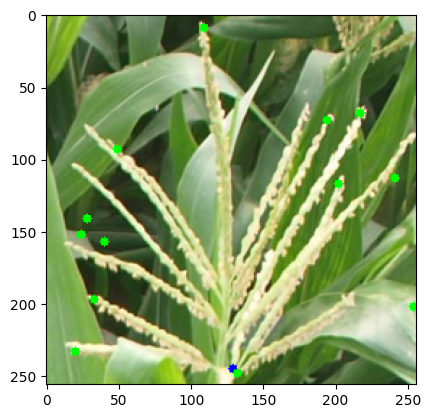

In [78]:
img_np = np.array(resized_img)
cv2.circle(img_np, (int(anchor.x), int(anchor.y)), 3, (0, 0, 255), -1)
for kp in parts:
    cv2.circle(img_np, (int(kp.x), int(kp.y)), 3, (0, 255, 0), -1)
plt.imshow(img_np)